In [237]:
import os
import json
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [238]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [239]:
FEATURES = 4
SCALER = False

## Dataset

We have 2 dataset :

    - One with all the data corresponding to the VM memory state (memproc, memvm, limit_cgroup ...)
    - One with response time values. 
    
The first one as a sampling size of 0.5s
The second one as a sampling frequency of 45s

In this work, we want to predict response time according to the VM memory state

In [307]:
'''
for each file containing VM memory state, we store data into a dict object called df
'''
list_of_files = []
dir_data = "data-extends"
for file in os.listdir(dir_data):
    if file.endswith(".csv") and file != "dataset.csv":
        list_of_files.append(os.path.join(dir_data,file)) #add file name to list of file name

df={}
for name in list_of_files:
    data = np.loadtxt(name,delimiter=",",skiprows=1) #load data, we skip first row that contains name of variables
    df[name] = {"time":data[:,1],"memused":data[:,2],"swapused":data[:,3],"memproc":data[:,4],"mem_vm":data[:,5],"limit_cgroup":data[:,6]}



In [308]:
'''
When we proceed a apach benchmarks, the result is store into a csv file. In order to have to the response-time, I write 
this small function that get the last line of benchmark, meaning the total time of execution of the benchmark. 
'''
def get_response_time_from_csv(file):
    data = np.loadtxt(file,delimiter=",",dtype=str)
    return data[-1][1]

print(get_response_time_from_csv("data/benchmarks_0.4/b00030.csv"))

231.836


In [309]:
'''
We store response_time of each experiments in a dict object called bench_dict 
'''
bench_dict = {}
for root, dirs, files in os.walk(".\data-extends"):
    for bench_dir in dirs:
        response_time = []
        for root,dirs,files in os.walk(os.path.join(root,bench_dir)):
            for bench_file in files:
                if os.path.splitext(bench_file)[1]==".csv":
                    file_path  = "data-extends/"+str(bench_dir)+"/"+str(bench_file)
                    response_time.append(get_response_time_from_csv(file_path))
        bench_dict[bench_dir] = response_time
        root = ".\data-extends"
    
for key_file in bench_dict.keys():
    print(bench_dict[key_file][0:5])


['1601.704', '269.785', '308.220', '269.486', '213.837']
['389.153', '265.421', '247.381', '238.084', '234.090']
['678.454', '447.450', '513.541', '307.054', '436.054']
['311.148', '279.271', '195.830', '275.415', '209.641']
['1555.690', '244.294', '199.625', '305.547', '340.583']
['572.034', '244.522', '386.692', '200.417', '520.142']
['249.943', '217.203', '189.872', '239.873', '193.881']
['273.722', '215.047', '249.761', '273.469', '211.208']
['348.150', '283.599', '237.297', '262.186', '213.064']
['252.327', '213.860', '308.191', '199.197', '272.915']
['508.478', '278.973', '230.655', '442.202', '274.799']
['304.460', '223.958', '335.741', '237.606', '344.865']
['448.267', '331.341', '279.453', '723.009', '216.992']


#### Data merging

Sampling frequency of benchmark and VM memory state are not the same. We have to merge them into a single dataset. 
I try two methods : 

   - One, I merge according to the sampling rate of benchmarks (45s). But I don't have many value, wich can be an issue during the learning of the model.
   - Second, I merge according to the sampling rate of the VM memory state (0.5s). But, we want to predict the response time, it mean that for a large set of values from memory state, the response time didn't change. That can lead to uncertainty during prediction
    
    

In [310]:
'''
first method, for each response_time value, we choose the VM memory state value corresponding to the time 
we launch the benchmark
'''
df_rt_sampling_rate ={}
for (bench,file) in zip(bench_dict.keys(),list_of_files):
    df_rt_sampling_rate[file] = {"time":[],"memused":[],"swapused":[],"memproc":[],"mem_vm":[],"limit_cgroup":[],"response_time":[]}
    bench_result = bench_dict[bench]
    coeff_map =  len(df[file]["time"])//len(bench_result)
    for i in range(len(bench_result)):
        for feature in df[file].keys():
            df_rt_sampling_rate[file][feature].append(df[file][feature][i*coeff_map-1])
        df_rt_sampling_rate[file]["response_time"].append(bench_result[i])

In [311]:
'''
second method, for each VM memory state values, we set the response time value corresponding to the benchmarks that
is launch at this time
'''
file = 0
for bench in bench_dict.keys():    
    bench_result = bench_dict[bench]
    df[list_of_files[file]]["response_time"] = []
    coeff_map =  len(df[list_of_files[file]]["time"])//len(bench_result)+1
    for i in range(len(df[list_of_files[file]]["time"])-1):
        df[list_of_files[file]]["response_time"].append(bench_result[i//coeff_map])
    df[list_of_files[file]]["response_time"].append(df[list_of_files[file]]["response_time"][-1])
    file+=1

#### Concatenate dataset

We concatenate all file value to one single dataset.

We choose to keep 6 or 4 features. 

If 6, we keep memused and swapused, that are memory used by the host and don't contains information of VM state. 
If 4, we don't keep them.

In [312]:
X_concatenate_7 = {"memused":[],"swapused":[],"memproc":[],"mem_vm":[],"limit_cgroup":[],"response_time":[]}
X_concatenate_4 = {"memproc":[],"mem_vm":[],"limit_cgroup":[],"response_time":[]}

In [313]:
features = FEATURES

In [314]:
if features==6:
    X_concatenate = X_concatenate_7
else : 
    X_concatenate = X_concatenate_4
for key in df.keys():
    for metric in X_concatenate.keys():
        X_concatenate[metric].extend(df[key][metric])

In [315]:
def process_data_from_df(df,n_future,n_past,n_past_response_time,show_plot=True,):
    
    def cut_df_in_windows(x_scaled):
        x_ = []
        y_ = []


        for i in range(n_past+n_past_response_time,len(x_scaled)-n_future+1):
            
            response_time = x_scaled[i-n_past-n_past_response_time:i-n_past_response_time,x_scaled.shape[1]-1]
            #print(response_time.shape)
            features = x_scaled[i-n_past:i,0:x_scaled.shape[1]-1]
            #print(features.shape)
            row_x_ = np.zeros((features.shape[0],features.shape[1]+1))
            for j in range(len(features)-1):
                    row_x_[j] = np.append(features[j],response_time[j])
                    #print(row_x_.shape)
            x_.append(row_x_)
            y_.append(x_scaled[i+n_future-1:i+n_future,x_scaled.shape[1]-1])
            

        x_ = np.array(x_)
        y_ = np.array(y_)
        print("x_ shape : {} - y_ shape : {}".format(x_.shape,y_.shape))
        return x_,y_
    
    x = pd.DataFrame(df,dtype=np.float64)
    dataset = x
    cols = list(x)[0:]
    df_x = x[cols].astype(float)
    
    if FEATURES == 6:    
        df_x["memused"] = df_x["memused"].apply(lambda x: x/1048576)
        df_x["swapused"] = df_x["swapused"].apply(lambda x: x/1048576)
    
    
    df_x["limit_cgroup"] = df_x["limit_cgroup"].apply(lambda x: x/1048576)
    df_x["memproc"] = df_x["memproc"].apply(lambda x: x/1048576)
    df_x["mem_vm"] = df_x["mem_vm"].apply(lambda x: x/1024)
    
    if show_plot:
        df_x.iloc[:,:-1].plot()
        df_x["response_time"].plot()
        
    x_to_be_cut = []
    scaler = StandardScaler()
        
    if SCALER:
        
        x_scaled = scaler.fit(df_x)
        x_scaled = scaler.transform(df_x)
        x_to_be_cut = x_scaled
        
        
    else :
        x_to_be_cut = df_x.to_numpy()


    print(x_to_be_cut.shape)
    x_,y_ = cut_df_in_windows(x_to_be_cut)
    return dataset,x_,y_,scaler

(78013, 4)
x_ shape : (77887, 25, 4) - y_ shape : (77887, 1)


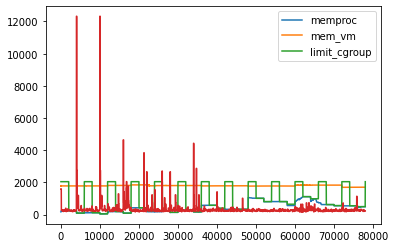

In [327]:
SCALER = False

n_future = 2
n_past = 25
n_past_response_time = 100

x,x_,y_,scaler = process_data_from_df(X_concatenate,n_future,n_past,n_past_response_time)
x.to_csv("data-extends/dataset.csv",index=False)

### data to train dataset

In [328]:
x_save,y_save = x_,y_

In [329]:
isshuffle=True

In [330]:
#on mélange le dataset
if isshuffle:
    x_,y_ = shuffle(x_, y_)

In [331]:
#On sépare le dataset en donnée d'entrainement et de test. 
# 80% -> test
# 20% -> entrainement
x_train = x_[:int(x_.shape[0]*0.8)]
y_train = y_[:int(x_.shape[0]*0.8)]
x_val = x_[int(x_.shape[0]*0.7):int(x_.shape[0]*0.8)]
y_val = y_[int(x_.shape[0]*0.7):int(x_.shape[0]*0.8)]
x_test = x_[int(x_.shape[0]*0.8):]
y_test = y_[int(x_.shape[0]*0.8):]

In [332]:
size_lstm_1,size_lstm_2 = 64,32
def lstm_model():
    
    inputs = layers.Input(shape=(x_train.shape[1],x_train.shape[2]), name="input")
    lstm_1 = layers.LSTM(size_lstm_1, activation="relu",return_sequences=True,name="lstm_layer_1")(inputs)
    lstm_2 = layers.LSTM(size_lstm_2, activation="relu",return_sequences=False,name="lstm_layer_2")(lstm_1)
    dropout = layers.Dropout(0.2)(lstm_2)
    output = layers.Dense(y_train.shape[1])(dropout)
    
    model = Model(inputs,output)
    
    return model

In [333]:
my_model = lstm_model()

In [334]:
my_model.compile(optimizer="adam",loss="mse")
my_model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 25, 4)]           0         
                                                                 
 lstm_layer_1 (LSTM)         (None, 25, 64)            17664     
                                                                 
 lstm_layer_2 (LSTM)         (None, 32)                12416     
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


In [335]:
history = my_model.fit(x_train,y_train,validation_split=0.1,epochs=10,batch_size=64,
                       verbose=1)

Epoch 1/10
877/877 [==============================] - 34s 35ms/step - loss: 864612.8125 - val_loss: 526836.1875
Epoch 2/10
877/877 [==============================] - 28s 32ms/step - loss: 488476.8750 - val_loss: 493282.3438
Epoch 3/10
877/877 [==============================] - 28s 32ms/step - loss: 467472.1250 - val_loss: 484380.4688
Epoch 4/10
877/877 [==============================] - 35s 40ms/step - loss: 451185.9375 - val_loss: 479348.0938
Epoch 5/10
877/877 [==============================] - 28s 32ms/step - loss: 443009.7812 - val_loss: 478505.5312
Epoch 6/10
877/877 [==============================] - 29s 33ms/step - loss: 448428.0000 - val_loss: 485838.8125
Epoch 7/10
877/877 [==============================] - 30s 34ms/step - loss: 444616.4375 - val_loss: 474422.7188
Epoch 8/10
877/877 [==============================] - 29s 33ms/step - loss: 443822.4688 - val_loss: 474241.2812
Epoch 9/10
877/877 [==============================] - 40s 45ms/step - loss: 468142.6562 - val_loss: 5076

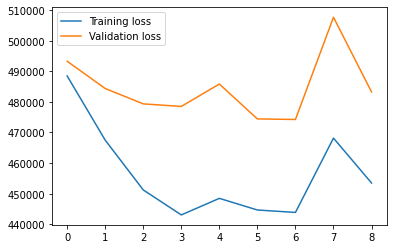

In [336]:
plt.plot(history.history['loss'][1:], label='Training loss')
plt.plot(history.history['val_loss'][1:], label='Validation loss')
plt.legend()
plt.show()

In [337]:
y_pred_tot = my_model.predict(x_save)

if SCALER:

    prediction_copies = np.repeat(prediction, features, axis=-1)
    y_pred_tot = scaler.inverse_transform(prediction_copies)[:,3]


    y_expected_copies = np.repeat(y_save, features, axis=-1)
    y_save = scaler.inverse_transform(y_expected_copies)[:,3]

In [301]:
y_pred_tot.shape,y_save.shape

((77893, 1), (77893, 1))

In [338]:
mean_squared_error(y_pred_tot,y_save)

453117.45496161736

C:\Users\alexi\AppData\Local\Temp\ipykernel_19928\2122564057.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_test = pd.DataFrame(df_curr,dtype=np.float)


(6001, 4)
x_ shape : (5875, 25, 4) - y_ shape : (5875, 1)
(5875, 25, 4)
mse = 2262346.9381248197


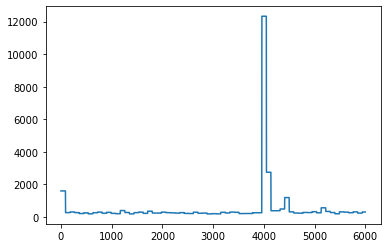

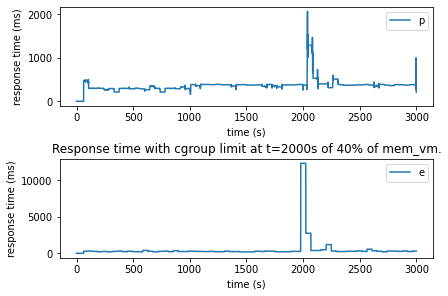

C:\Users\alexi\AppData\Local\Temp\ipykernel_19928\2122564057.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_test = pd.DataFrame(df_curr,dtype=np.float)


(6001, 4)
x_ shape : (5875, 25, 4) - y_ shape : (5875, 1)
(5875, 25, 4)
mse = 2262193.6549634044


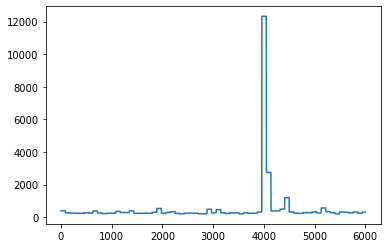

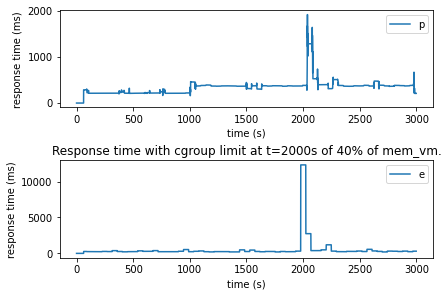

C:\Users\alexi\AppData\Local\Temp\ipykernel_19928\2122564057.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_test = pd.DataFrame(df_curr,dtype=np.float)


(6001, 4)
x_ shape : (5875, 25, 4) - y_ shape : (5875, 1)
(5875, 25, 4)
mse = 407019.93868225976


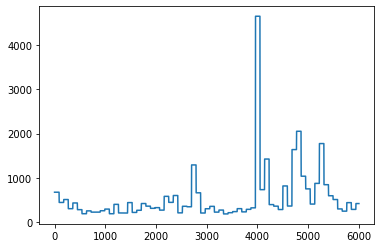

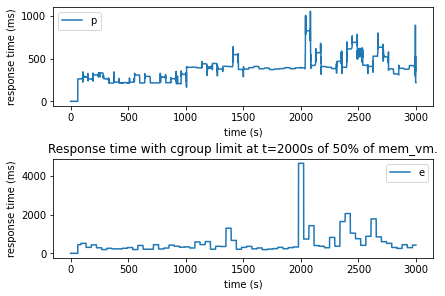

C:\Users\alexi\AppData\Local\Temp\ipykernel_19928\2122564057.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_test = pd.DataFrame(df_curr,dtype=np.float)


(6001, 4)
x_ shape : (5875, 25, 4) - y_ shape : (5875, 1)
(5875, 25, 4)
mse = 306697.12787115487


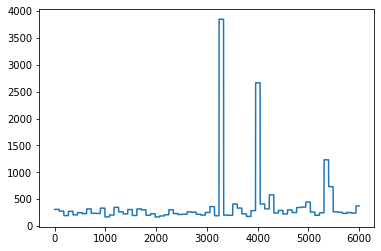

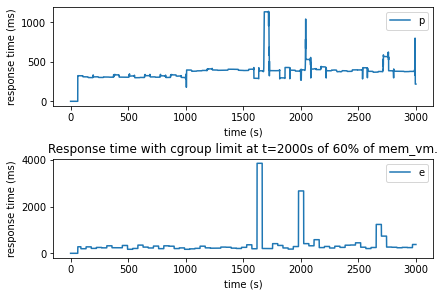

C:\Users\alexi\AppData\Local\Temp\ipykernel_19928\2122564057.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_test = pd.DataFrame(df_curr,dtype=np.float)


(6001, 4)
x_ shape : (5875, 25, 4) - y_ shape : (5875, 1)
(5875, 25, 4)
mse = 208777.8540284979


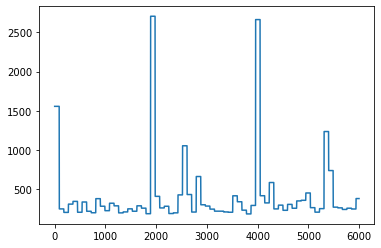

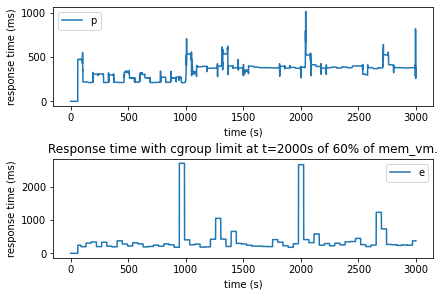

C:\Users\alexi\AppData\Local\Temp\ipykernel_19928\2122564057.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_test = pd.DataFrame(df_curr,dtype=np.float)


(6001, 4)
x_ shape : (5875, 25, 4) - y_ shape : (5875, 1)
(5875, 25, 4)
mse = 378492.2091011853


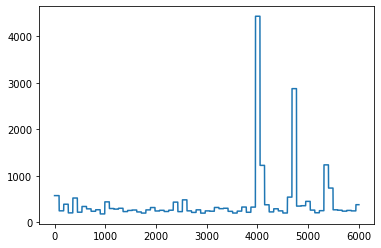

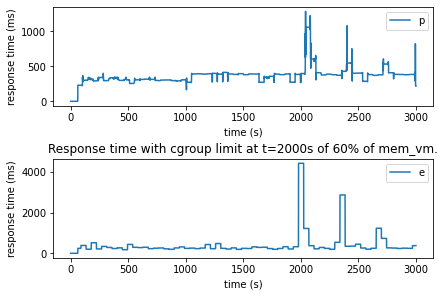

C:\Users\alexi\AppData\Local\Temp\ipykernel_19928\2122564057.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_test = pd.DataFrame(df_curr,dtype=np.float)


(6001, 4)
x_ shape : (5875, 25, 4) - y_ shape : (5875, 1)
(5875, 25, 4)
mse = 33092.14928706161


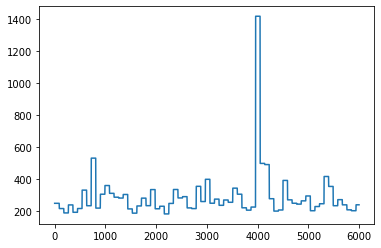

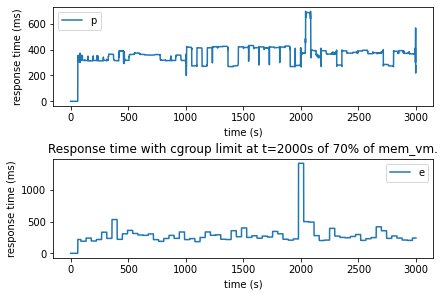

C:\Users\alexi\AppData\Local\Temp\ipykernel_19928\2122564057.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_test = pd.DataFrame(df_curr,dtype=np.float)


(6001, 4)
x_ shape : (5875, 25, 4) - y_ shape : (5875, 1)
(5875, 25, 4)
mse = 17690.58760140039


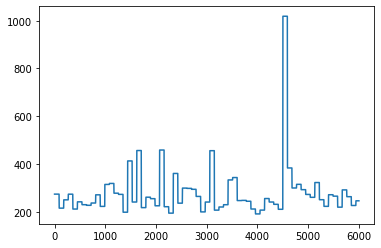

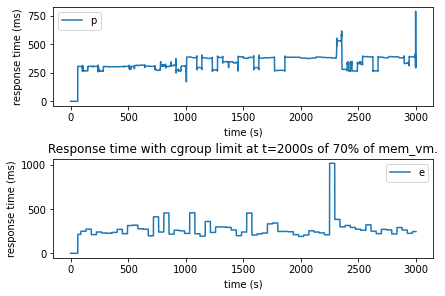

C:\Users\alexi\AppData\Local\Temp\ipykernel_19928\2122564057.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_test = pd.DataFrame(df_curr,dtype=np.float)


(6001, 4)
x_ shape : (5875, 25, 4) - y_ shape : (5875, 1)
(5875, 25, 4)
mse = 25972.862940068964


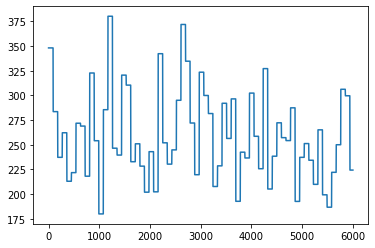

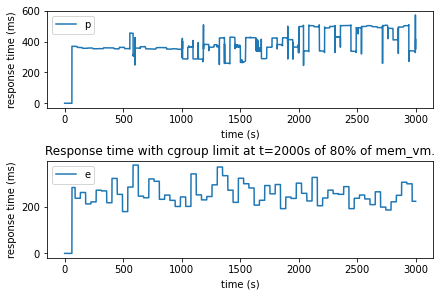

C:\Users\alexi\AppData\Local\Temp\ipykernel_19928\2122564057.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_test = pd.DataFrame(df_curr,dtype=np.float)


(6001, 4)
x_ shape : (5875, 25, 4) - y_ shape : (5875, 1)
(5875, 25, 4)
mse = 17204.576716159765


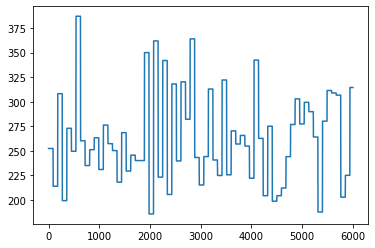

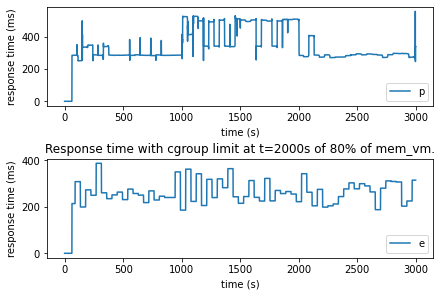

C:\Users\alexi\AppData\Local\Temp\ipykernel_19928\2122564057.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_test = pd.DataFrame(df_curr,dtype=np.float)


(6001, 4)
x_ shape : (5875, 25, 4) - y_ shape : (5875, 1)
(5875, 25, 4)
mse = 22491.98167032026


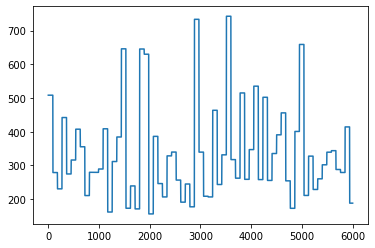

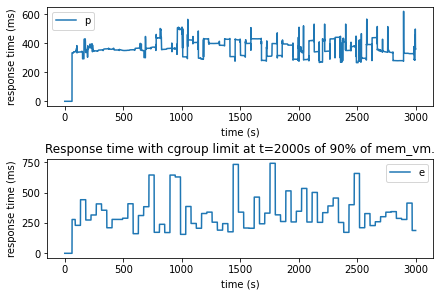

C:\Users\alexi\AppData\Local\Temp\ipykernel_19928\2122564057.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_test = pd.DataFrame(df_curr,dtype=np.float)


(6001, 4)
x_ shape : (5875, 25, 4) - y_ shape : (5875, 1)
(5875, 25, 4)
mse = 10603.31070163617


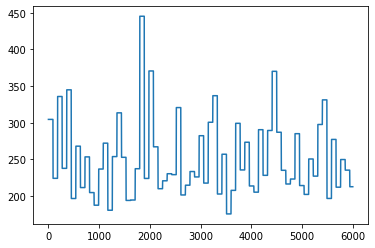

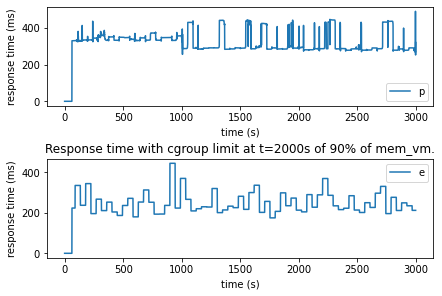

C:\Users\alexi\AppData\Local\Temp\ipykernel_19928\2122564057.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_test = pd.DataFrame(df_curr,dtype=np.float)


(6001, 4)
x_ shape : (5875, 25, 4) - y_ shape : (5875, 1)
(5875, 25, 4)
mse = 22448.05756256519


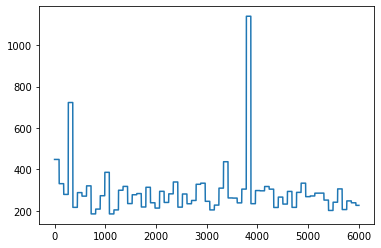

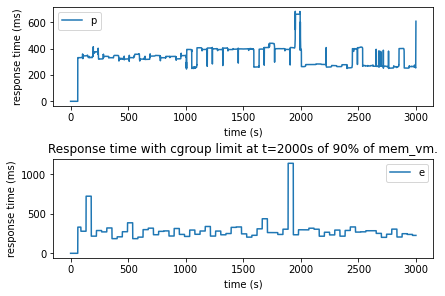

In [339]:
for dataset in df.keys():
    
    
    df_curr = df[dataset].copy()
    
    df_test = pd.DataFrame(df_curr,dtype=np.float)
    df_test["response_time"].plot()
    
    df_curr.pop("time",None)
    
    if FEATURES == 4:
        df_curr.pop("memused",None)
        df_curr.pop("swapused",None)
    
    d,x_,y_,scaler_bis = process_data_from_df(df_curr,n_future,n_past,n_past_response_time,show_plot=False)
    
    
    print(x_.shape)
    y_pred = my_model.predict(x_)
    print("mse = {}".format(mean_squared_error(y_pred,y_)))
    
    if SCALER:
        y_pred_copies = np.repeat(y_pred, 6, axis=-1)
        y_pred = scaler_bis.inverse_transform(y_pred_copies)[0]
   
    
        y_expected = np.repeat(y_, n_past, axis=-1)
        y_ = scaler_bis.inverse_transform(y_)[0]

    
    n_y_pred = len(y_pred)+n_past+n_past_response_time

    y_label = [y*(3000/n_y_pred) for y in range(n_y_pred)]
    y_pred = np.insert(y_pred,0,[0 for y in range(n_past+n_past_response_time)])
    y_ = np.insert(y_,0,[0 for y in range(n_past+n_past_response_time)])
    
   
    fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
    
    
    ax1.plot(y_label,y_pred)
    ax1.set_xlabel("time (s)")
    ax1.set_ylabel("response time (ms)")
    ax1.set_facecolor('w')
    ax1.legend("prediction")
    #ax1.set_ylim(0,12000)
    #ax1.set_title("Predicted outputs")
    
    
    ax2.plot(y_label,y_)
    ax2.set_xlabel("time (s)")
    ax2.set_ylabel("response time (ms)")
    ax2.set_facecolor('w')
    ax2.legend("expected")
    #ax2.set_ylim(0,12000)
    
    #ax2.set_title("Expected outputs")
    
    file_name = dataset.split("\\")[1].split(".")[0]
    reduction = file_name[5]
    num_experience = file_name[6]
    
    plt.title("Response time with cgroup limit at t=2000s of "+reduction+"0% of mem_vm.")
    #plt.text("experience num:"+num_experience,0,400)
    
    
    fig.savefig("plot-result-ter/"+file_name+".jpg",transparent=False)
    plt.show()
    
    
    
   

In [341]:
try:
    my_model.save("model_predict_tr_vm_V2",save_format="tf")
except Exception:
    my_model.save("model_predict_tr_vm_V2.h5")

INFO:tensorflow:Assets written to: model_predict_tr_vm_V2\assets


INFO:tensorflow:Assets written to: model_predict_tr_vm_V2\assets


In [305]:
r1,r2 = 12000,18000

In [306]:
for (r1,r2) in zip(range(len(list_of_files)),range(1,len(list_of_files)+1)):
    
    
    y_label = [y/2 for y in range(len(y_pred_future[r1*(6000//coeff_map):r2*(6000//coeff_map)]))]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
    
    
    ax1.plot(y_label,y_pred_future[r1*(6000//coeff_map):r2*(6000//coeff_map)])
    ax1.set_xlabel("time (s)")
    ax1.set_ylabel("response time (ms)")
    ax1.set_facecolor('w')
    ax1.legend("prediction")
    #ax1.set_title("Predicted outputs")
    
    
    ax2.plot(y_label,y_expected_future[r1*(6000//coeff_map):r2*(6000//coeff_map)])
    ax2.set_xlabel("time (s)")
    ax2.set_ylabel("response time (ms)")
    ax2.set_facecolor('w')
    ax2.legend("expected")
    
    #ax2.set_title("Expected outputs")
    
    file_name = list_of_files[r1].split("\\")[1].split(".")[0]
    reduction = file_name[5]
    num_experience = file_name[6]
    
    plt.title("Response time with cgroup limit at t=2000s of "+reduction+"0% of mem_vm.")
    #plt.text("experience num:"+num_experience,0,400)
    
    
    fig.savefig("plot-result-ter/"+file_name+".png",transparent=False)
    plt.show()
    
    

NameError: name 'y_pred_future' is not defined

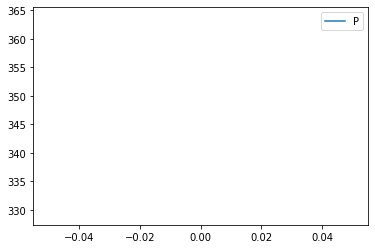

In [110]:
y_label = [y/2 for y in range(len(y_pred_future[r1:r2]))]
plt.plot(y_label,y_pred_future[r1:r2])
plt.legend("Predicted outputs")
plt.show()

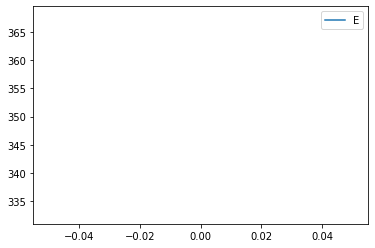

In [111]:
plt.plot(y_label,y_expected_future[r1:r2])
plt.legend("Expected outputs")
plt.show()

In [149]:
with open('save_result.json') as json_file:
    result = json.load(json_file)
    
index = result[-1]["id"]+1
result.append({
        "id" : index,
		"features":x_train.shape[2],
		"n_future" : n_future,
		"model" :"bi-LSTM, ("+str(size_lstm_1)+","+str(size_lstm_2)+") - "+str(x_train.shape[2])+" features - n_futur :" + str(n_future),
		"response_time_feature" : True,
		"mse":mse,
        "shuffle":isshuffle
	})
# Convert the dictionary into a JSON string
json_string = json.dumps(result)

# Save the JSON string into a file
with open("save_result.json", "w") as f:
    f.write(json_string)

C:\Users\alexi\AppData\Local\Temp\ipykernel_17684\268186211.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r_df = r_df.append({
C:\Users\alexi\AppData\Local\Temp\ipykernel_17684\268186211.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r_df = r_df.append({
C:\Users\alexi\AppData\Local\Temp\ipykernel_17684\268186211.py:5: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  r_df = r_df.append({
C:\Users\alexi\AppData\Local\Temp\ipykernel_17684\268186211.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r_df = r_df.append({
C:\Users\alexi\AppData\Local\Temp\ipykernel_17684\268186211.py:5: Future

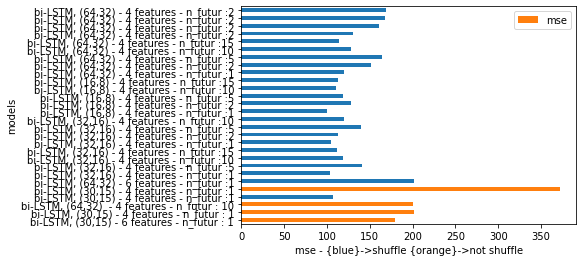

In [150]:
with open('save_result.json') as json_file:
    result = json.load(json_file)
r_df = pd.DataFrame(columns=["models","mse","shuffle"])   
for r in result:
    r_df = r_df.append({
        "models" : r["model"],
        "mse" : float(r["mse"]),
        "shuffle" : r["shuffle"]
    },
    ignore_index=True)
    
def color_is_shuffle(shuffle):
    color_list = []
    for sh in shuffle:
        if sh:
            color_list.append('tab:blue')
        else : 
            color_list.append('tab:orange')
    return color_list
# Create a bar plot
r_df.plot.barh(x='models',y='mse',color=color_is_shuffle(r_df["shuffle"]),rot=0)
#plt.ylim(50, 400)
plt.xlabel("mse - {blue}->shuffle {orange}->not shuffle")

# Show the plot
plt.show()

In [151]:
df_pred = pd.DataFrame(y_pred_future)
df_pred.to_csv("result-data/model_extends_"+str(size_lstm_1)+"_"+str(size_lstm_2)+"_nfuture"+str(n_future)+"_npast"+str(n_past)+"_features"+str(x_train.shape[2])+".csv")

##### Observations :

- Détection du pic à ~2000s
- Dans prédiction, le pic est avant la réalité
- La valeur du temps de réponse est nettement supérieur à ce qui est réellement observé

//IS DO

- Diminuer le nombre de features -> garder mem_proc,mem_vm,limit_cgroup et response_time
- Faire varier n_futur et observer les résultas
- Supprimer les premières valeurs des dataset de temps de réponse -> valeurs incohérentes

//TODO

- Plot les topologies issues des predictions des différents models 
- Créer les VMs (une VM)
- Enrechir le dataset



